## Notebook to plot predictions of graph vs MLP

### plot examples predictions and distance on patients
### plot salient vertices and saliencies


In [1]:
import meld_graph.experiment
import os
import numpy as np
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350
Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


In [2]:
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


In [15]:
model_graph = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all/results_best_model'
# model_pervertex = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15_nothresh/ensemble_21-09-15'
model_pervertex= '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'

In [16]:
model_graph ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all'
exp = meld_graph.experiment.Experiment.from_folder(model_graph)

features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )

Initialised Experiment 23-10-30_FOPF_dcop/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all


In [18]:
with h5py.File(os.path.join(model_graph, 'results_best_model', 'predictions.hdf5'), "r") as f:
    subjects_test = list(f.keys())
len(subjects_test)

453

In [19]:
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image

def load_predictions_for_subject(subj,model_dir,cohort,):
    #load mask
    s = MeldSubject(subj,cohort=cohort)
    hemi=s.get_lesion_hemisphere()
    dists, label = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
    seg_pred = np.zeros(len(cohort.cortex_mask))
    dist_pred = np.zeros(len(cohort.cortex_mask))
    pred_file = os.path.join(model_dir, 'predictions.hdf5')
    result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
    seg_pred[cohort.cortex_mask] = result_hemis[hemi]
    distance_map = load_prediction(subj,pred_file, dset='distance_map')
    dist_pred[cohort.cortex_mask] = distance_map[hemi]
    file = os.path.join(model_pervertex, 'predictions_ensemble_iteration.hdf5')
    per_vertex = np.zeros(len(cohort.cortex_mask))
    per_vertex[cohort.cortex_mask] = load_prediction(subj,file, dset='prediction')[hemi]
    return label,seg_pred,dist_pred,per_vertex
    

In [20]:
# initialise subjects
subjects=[    
        'MELD_H21_15T_FCD_0050',
        'MELD_H4_3T_FCD_0016',
        ]

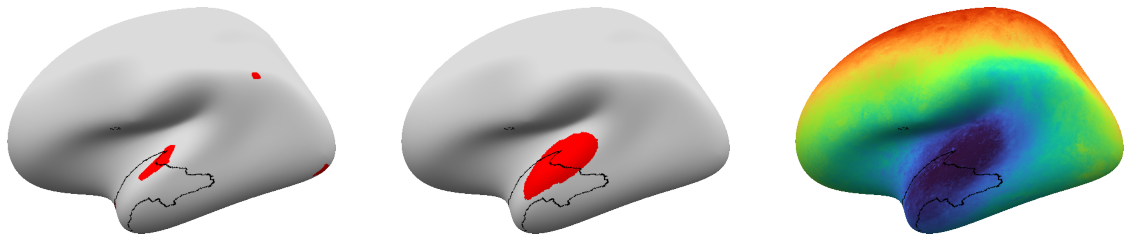

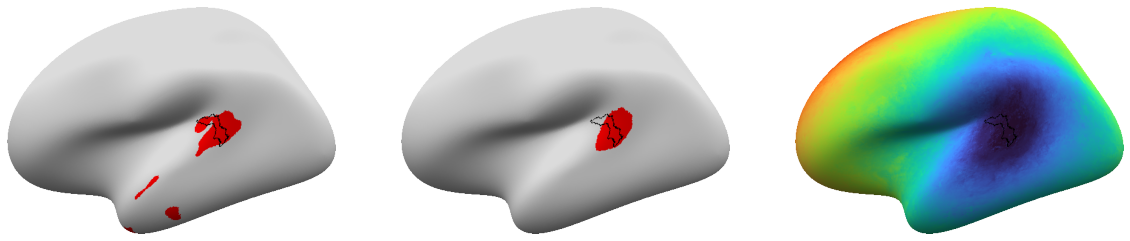

In [23]:
## plot prediction against MLP

for subj in subjects:
    # get predictions and distance maps
    label,seg_pred,dist_pred,per_vertex = load_predictions_for_subject(subj, os.path.join(model_graph, 'results_best_model'),cohort)

    #plot predictions using per-vertex graph
    per_vertex = per_vertex>0
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],per_vertex,rotate=[90],
        cmap='bwr',
        base_size = 20,filename='tmp1.png', colorbar=False,mask=~per_vertex,
        parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_pv = trim(im)

    #plot predictions new graph and distance
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],seg_pred,
                  rotate=[90],cmap='bwr',
                    base_size = 20,filename='tmp1.png', colorbar=False,mask=~seg_pred.astype(bool),
                    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_graph = trim(im)
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],dist_pred,
                  rotate=[90],cmap='turbo',
                    base_size = 20,filename='tmp1.png', colorbar=False,#mask=~per_vertex,
                    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_dist = trim(im)

    #combine plots
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax[0].imshow(trimmed_pv)
    ax[1].imshow(trimmed_graph)
    ax[2].imshow(trimmed_dist)
    for ax in ax:
        ax.axis('off')

    #save plot
    plt.savefig(f'{model_graph}/results_best_model/images/examples_patients_graphvsMLP_{subj}.png', transparent=True)



### plot salient vertices and saliencies 

In [2]:
from meld_graph.dataset import GraphDataset
from meld_graph.evaluation import Evaluator
import matplotlib as mpl
import matplotlib.cm as cm
from meld_graph.data_preprocessing import Preprocess
from meld_graph.confidence import get_confidence
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image


In [3]:

def get_subj_data(subject_id, eva):
    
    #load data for that subject
    data_dictionary = eva.load_data_from_file(subject_id, keys=['result','cluster_thresholded','input_features'], 
                                          split_hemis=False, 
                                          save_prediction_suffix=save_prediction_suffix)
    features_vals = data_dictionary['input_features']
    predictions = data_dictionary['cluster_thresholded']

    #find thresholds used if two thresholds
    if isinstance(eva.threshold, np.ndarray):
        if data_dictionary['result'].max() > eva.threshold[1]:
            threshold = eva.threshold[1]
        else :
            threshold = eva.threshold[0]
    else:
        threshold = eva.threshold
        
    #find clusters and load saliencies 
    list_clust = set(predictions)
    list_clust.remove(0.0)
    keys = [f'saliencies_{cl}' for cl in list_clust] + [f'mask_salient_{cl}' for cl in list_clust]
    saliencies = eva.load_data_from_file(subject_id, 
                                        keys=keys, 
                                        split_hemis=False, 
                                        save_prediction_suffix=save_prediction_suffix)
        
    # add confidence per cluster on salient vertices
    confidence_v = get_confidence(eva, [subject_id], eva.cohort, threshold=threshold)
    confidences = {}
    for cl in list_clust:
        confidences[f'confidence_{cl}'] =  confidence_v[subject_id]['confidence_lesion'][saliencies[f'mask_salient_{cl}'].astype(bool)]

    return list_clust, features_vals, predictions, threshold, saliencies, confidences

def plot_mask(mask, cohort, vmax=1):
    #split mask in left and right
    mask_hemi = cohort.split_hemispheres(mask)
    if mask_hemi['left'].sum()>0:
        overlay = mask_hemi['left']
    else:
        overlay = mask_hemi['right']
    
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],overlay,
                    rotate=[90],cmap='magma', label=True,
                        base_size = 20,filename='tmp1.png', colorbar=False,mask=~overlay.astype(bool),
                        vmin=0, vmax=vmax
                        )
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_dist = trim(im)
    return trimmed_dist

    

In [4]:
# load experiment
model_graph = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all'
exp = meld_graph.experiment.Experiment.from_folder(model_graph)
exp.data_parameters["augment_data"] = {}

#load trainval dataset
split = "test"

# subjects = exp.data_parameters["test_ids"]
subjects=['MELD_H21_15T_FCD_0050']

features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )
dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode="test")
save_prediction_suffix=""

# create evaluator
eva = Evaluator(
    experiment=exp,
    checkpoint_path=model_graph,
    make_images=False,
    dataset=dataset,
    # save_dir=save_dir,
    cohort=cohort,
    subject_ids=subjects,
    mode="test",
    thresh_and_clust=True,
)


Initialised Experiment 23-10-30_FOPF_dcop/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H21_15T_FCD_0050
Evaluation test, min area threshold=100, threshold two_threshold(ymin=0.03, ymax=0.5)
Creating model
Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_FOPF_dcop/s_0/fold_all/best_model.pt
Predicting model without dropout


using dataset


Loading and preprocessing test data
Z-scoring data for MELD_H21_15T_FCD_0050


1.0


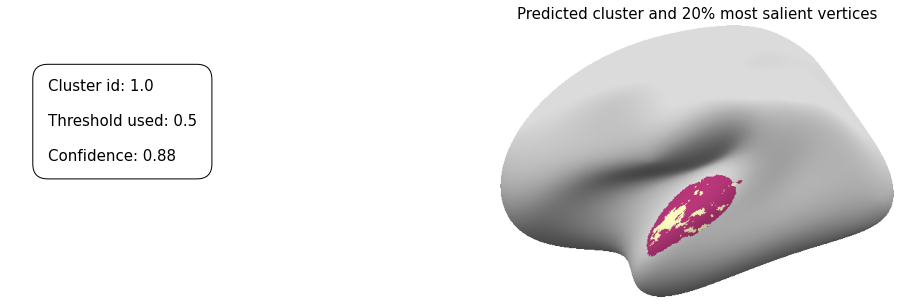

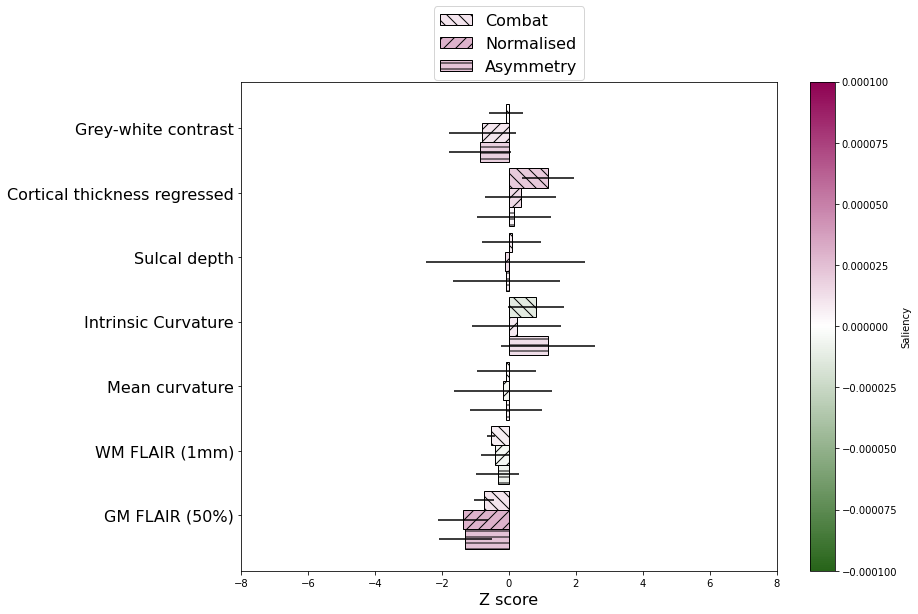

In [6]:
#with evaluator 


subject_id=subjects[0]

#load data for that subject
list_clust, features_vals, predictions, threshold, saliencies, confidences  = get_subj_data(subject_id, eva)

base_feature_set = [
        ".on_lh.gm_FLAIR_0.5.sm3.mgh",
        ".on_lh.wm_FLAIR_1.sm3.mgh",
        ".on_lh.curv.sm3.mgh",
        ".on_lh.pial.K_filtered.sm20.mgh",
        ".on_lh.sulc.sm3.mgh",
        ".on_lh.thickness_regression.sm3.mgh",
        ".on_lh.w-g.pct.sm3.mgh",
    ]

feature_names_set = [
        "GM FLAIR (50%)",
        "WM FLAIR (1mm)",
        "Mean curvature",
        "Intrinsic Curvature",
        "Sulcal depth",
        "Cortical thickness regressed",
        "Grey-white contrast",
    ]
  
#check if subject has FLAIR
if features_vals[features.index('.combat.on_lh.gm_FLAIR_0.5.sm3.mgh')].sum()>0:
    base_features = base_feature_set
    feature_names = feature_names_set
else:
    base_features = base_feature_set[2:]
    feature_names = feature_names_set[2:]
    
#initiate params for saliencies
prefixes = [".combat", ".inter_z.intra_z.combat", ".inter_z.asym.intra_z.combat"]
names = ["combat", "norm", "asym"]
lims = 1e-4
norm = mpl.colors.Normalize(vmin=-lims, vmax=lims)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "grpr",
    colors=[
        "#276419",
        "#FFFFFF",
        "#8E0152",
    ],
)
m = cm.ScalarMappable(norm=norm, cmap=cmap)
labels = ["Combat", "Normalised", "Asymmetry"]
hatching = ["\\\\", "//", "--"]


# loop over clusters
for cluster in list_clust:
    print(cluster)
    
    fig,ax = plt.subplots(1,2,figsize=(16,5))    
    
    fig2 = plt.figure(figsize=(12, 9))
    ax2 = fig2.add_subplot()
    
    #plot info cluster
    # threshold = 'NA'
    confidence = round(confidences[f'confidence_{cluster}'].mean(),2)
    text = f'Cluster id: {cluster}\n\nThreshold used: {threshold}\n\nConfidence: {str(confidence)}'
    ax[0].text(0.1, 0.5, text, color='black', fontsize=15,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    ax[0].set_axis_off()
    
    # get mean saliencies
    saliencies_cl = saliencies[f'saliencies_{cluster}']
    mean_saliencies = saliencies_cl.mean(axis=1)

    # plot prediction and salient vertices
    mask = np.array([predictions == cluster])[0]
    mask_salient = saliencies[f'mask_salient_{cluster}']
    # mask_comb = mask.astype(int)*2
    # mask_comb[mask_salient.astype(bool)] = 1
    mask_comb = mask.astype(int)+mask_salient.astype(int)
    
    im = plot_mask(mask_comb, cohort, vmax=2)
    ax[1].imshow(im)
    ax[1].set_axis_off()
    ax[1].set_title('Predicted cluster and 20% most salient vertices', fontsize=15)
    
    # plot saliencies
    for pr, prefix in enumerate(prefixes):
        cur_data = np.zeros(len(base_features))
        cur_err = np.zeros(len(base_features))
        saliency_data = np.zeros(len(base_features))
        for b, bf in enumerate(base_features):
            cur_data[b] = np.mean(
                            features_vals[mask, features.index(prefix + bf)]
                        )
            cur_err[b] = np.std(
                            features_vals[mask, features.index(prefix + bf)]
                        )
            saliency_data[b] = np.mean(
                            saliencies_cl[mask ,features.index(prefix + bf)]
                            )
        
        ax2.barh(
            y=np.array(range(len(base_features))) - pr * 0.3,
            width=cur_data,
            hatch=hatching[pr],
            height=0.3,
            edgecolor="k",
            xerr=cur_err,
            label=labels[pr],
            color=m.to_rgba(saliency_data),
        )
    ax2.set_xlim([-8, 8])
    ax2.set_yticks(np.array(range(len(base_features))) - 0.23)
    ax2.set_yticklabels(feature_names, fontsize=16)
    ax2.set_xlabel("Z score", fontsize=16)
    ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.17), fontsize=16)
    fig2.colorbar(m, label=f"Saliency", ax=ax2, )
    ax2.set_autoscale_on(True)

    # save plot
    # os.makedirs(images_dir, exist_ok=True)
    # fig2.savefig(os.path.join(images_dir,f'{subject_id}_cl{cluster}_saliencies.png'))

In [34]:
def calculate_circle_dataset(center,radius, spherical_coords):
    """calculate circle of radius around center"""
    all_distances = np.linalg.norm(spherical_coords-center,axis=1)
    circle = all_distances<radius
    return circle,all_distances

def plot_object_detection_output(xyzr, cohort, icospheres,fname):
    sphere = icospheres.icospheres[7]
    spherical_coords = sphere['coords']/100
    mask,dists = calculate_circle_dataset(xyzr[:3],xyzr[3],
                         spherical_coords)
    msp.plot_surf(cohort.surf['coords'],
              icospheres.icospheres[7]['faces'],
              #dataset[0]['distance_map'].detach().numpy(),
              mask,
              cmap='turbo',rotate=[90,270],
              filename=fname
              )
    return

In [ ]:
plot_object_detection_output(estimates['object_detection_linear'].detach().numpy()[i], cohort, icospheres, fname=f'preds/sub_obj_{i}.png')

In [60]:
predictions

array([0., 0., 0., ..., 0., 0., 0.])

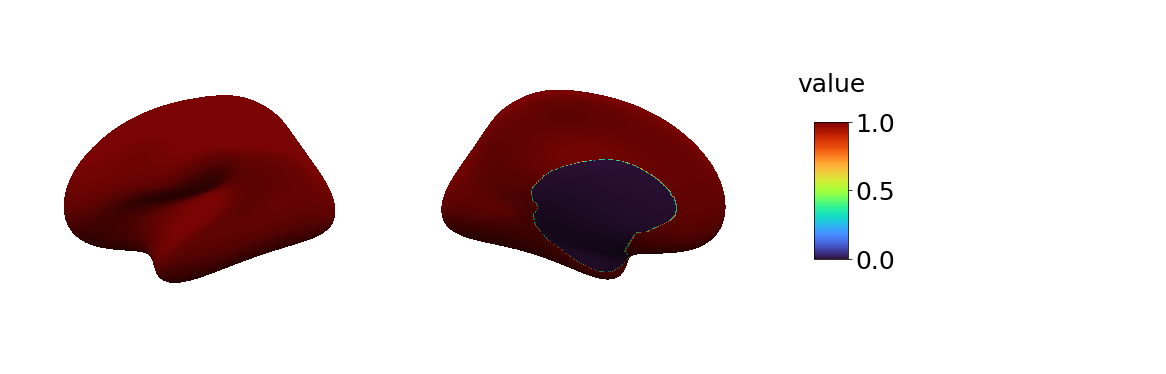

In [59]:
from meld_graph.icospheres import IcoSpheres

icospheres = IcoSpheres()
sphere = icospheres.icospheres[7]
spherical_coords = sphere['coords']/100
mask,dists = calculate_circle_dataset(xyzr[:3],xyzr[3],spherical_coords)


msp.plot_surf(cohort.surf['coords'],
            icospheres.icospheres[7]['faces'],
            #dataset[0]['distance_map'].detach().numpy(),
            cohort.cortex_mask,
            cmap='turbo',rotate=[90,270],
            # filename=fname
            )

In [ ]:
# def get_subj_data(subject_id, pred_file, cohort ):
#     #load data for that subject
#     s = MeldSubject(subject_id,cohort=cohort)
#     hemi=s.get_lesion_hemisphere()
#     features_vals, labels = s.load_feature_lesion_data(features, hemi=hemi)
#     predictions = np.zeros(len(cohort.cortex_mask))
#     predictions[cohort.cortex_mask] = load_prediction(subject_id,pred_file, dset='prediction_clustered')[hemi]

#     #find clusters and load saliencies 
#     list_clust = set(predictions)
#     list_clust.remove(0.0)
#     print(len(list_clust))
#     saliencies={}
#     salient_mask={}
#     for cl in list_clust:
#         saliencies_c= load_prediction(subject_id,pred_file, dset=f'saliencies_{cl}')[hemi]
#         saliencies[f'saliencies_{cl}'] = np.zeros((len(cohort.cortex_mask), saliencies_c.shape[1]))
#         saliencies[f'saliencies_{cl}'][cohort.cortex_mask] = saliencies_c
        
#         salient_mask_c= load_prediction(subject_id,pred_file, dset=f'mask_salient_{cl}')[hemi]
#         salient_mask[f'mask_salient_{cl}'] = np.zeros((len(cohort.cortex_mask))).astype(bool)
#         salient_mask[f'mask_salient_{cl}'][cohort.cortex_mask] = salient_mask_c.astype(bool)
        
#         # confidence = 
#     return predictions, labels, features_vals, saliencies, salient_mask

# def plot_mask(mask, cohort):
#     msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],mask,
#                     rotate=[90],cmap='turbo',
#                         base_size = 20,filename='tmp1.png', colorbar=False,mask=~mask)
#     plt.close()
#     im = Image.open('tmp1.png')
#     trimmed_dist = trim(im)
#     return trimmed_dist

# def get_threshold(exp):
#     threshold_file = os.path.join(self.experiment.experiment_path, f'results_{model_name}', "two_thresholds.csv")

In [53]:
# #without evaluator # not working
# # 
# # 
# import matplotlib as mpl
# import matplotlib.cm as cm

# from meld_graph.data_preprocessing import Preprocess

# predictions, labels_lesion, features_vals, saliencies, salient_masks, confidence = get_subj_data(subject_id, pred_file, cohort )

# #create preprocess object
# prep = Preprocess(cohort)
# prep.load_z_params(file=exp.data_parameters['preprocessing_parameters']['zscore'])
# #preprocess features
# features_vals = prep.zscore_data(features_vals.T, np.array(features)).T

# #check if subject has FLAIR
# if features_vals[features.index('.combat.on_lh.gm_FLAIR_0.5.sm3.mgh')].sum()>0:
#     base_features = base_feature_set
#     feature_names = feature_names_set
# else:
#     base_features = base_feature_set[2:]
#     feature_names = feature_names_set[2:]


# #initiate params for saliencies
# prefixes = [".combat", ".inter_z.intra_z.combat", ".inter_z.asym.intra_z.combat"]
# names = ["combat", "norm", "asym"]
# lims = 1e-4
# norm = mpl.colors.Normalize(vmin=-lims, vmax=lims)
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     "grpr",
#     colors=[
#         "#276419",
#         "#FFFFFF",
#         "#8E0152",
#     ],
# )
# m = cm.ScalarMappable(norm=norm, cmap=cmap)
# labels = ["Combat", "Normalised", "Asymmetry"]
# hatching = ["\\\\", "//", "--"]

# list_clust = set(predictions)
# list_clust.remove(0.0)
# # loop over clusters
# for cluster in list_clust:
#     fig,ax = plt.subplots(1,3,figsize=(10,5))    
    
#     fig2 = plt.figure(figsize=(17, 9))
#     ax2 = fig2.add_subplot()
    
#     # plot info cluster
#     thresh = get_threshold()
#     text=f'Cluster {cluster}\nThreshold {thresh}\nConfidence {confidence}'
#     ax[0].text(0.5, 0.2, text, color='black', 
#         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    
#     # plot prediction
#     mask = np.array([predictions == cluster])[0]
#     im =plot_mask(mask,cohort)
#     ax[1].imshow(im)  
#     ax[1].set_axis_off()
    
#     # get mean saliencies
#     saliencies_cl = saliencies[f'saliencies_{cluster}']
#     mean_saliencies = saliencies_cl.mean(axis=1)
#     # plot salient vertices
#     mask = salient_masks[f'mask_salient_{cluster}']
#     im =plot_mask(mask,cohort)
#     ax[2].imshow(im)
#     ax[2].set_axis_off()
#     # plot saliencies
#     for pr, prefix in enumerate(prefixes):
#         cur_data = np.zeros(len(base_features))
#         cur_err = np.zeros(len(base_features))
#         saliency_data = np.zeros(len(base_features))
#         for b, bf in enumerate(base_features):
#             cur_data[b] = np.mean(
#                             features_vals[mask, features.index(prefix + bf)]
#                         )
#             cur_err[b] = np.std(
#                             features_vals[mask, features.index(prefix + bf)]
#                         )
#             saliency_data[b] = np.mean(
#                             saliencies_cl[mask ,features.index(prefix + bf)]
#                             )
        
#         ax2.barh(
#             y=np.array(range(len(base_features))) - pr * 0.3,
#             width=cur_data,
#             hatch=hatching[pr],
#             height=0.3,
#             edgecolor="k",
#             xerr=cur_err,
#             label=labels[pr],
#             color=m.to_rgba(saliency_data),
#         )
#     ax2.set_xlim([-8, 8])
#     ax2.set_yticks(np.array(range(len(base_features))) - 0.23)
#     ax2.set_yticklabels(feature_names, fontsize=16)
#     ax2.set_xlabel("Z score", fontsize=16)
#     ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.17), fontsize=16)
#     fig2.colorbar(m, label=f"Saliency", ax=ax2, )
#     ax2.set_autoscale_on(True)

#     # save plot
#     # os.makedirs(images_dir, exist_ok=True)
#     # fig2.savefig(os.path.join(images_dir,f'{subject_id}_cl{cluster}_saliencies.png'))

1


ValueError: not enough values to unpack (expected 6, got 5)

In [100]:
features.index(prefix + bf)

7

In [99]:
features_vals.shape

(163842, 34)